In [1]:
import numpy as np
import sklearn
import scipy
import pickle as pickle
import glob
import os
import moviepy
import skimage.measure
import seaborn as sns 
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
from general.plotting import *
from general.datasets import *

Using TensorFlow backend.


# Load images

In [117]:
DATA_PATH = "data"
TRAINING_DATA_PATH = "data/preprocessing/training"
TEST_DATA_PATH = "data/preprocessing/test"
BACKGROUNDS_DIR = 'backgrounds'

directory_to_labels_mapping = {
    'bart': 'bart', 'marge': 'marge', 'homer': 'homer', 'lisa': 'lisa', 
#    'bart': 'bart', 'marge': 'marge', 'maggie': 'maggie',
}

def crop_empty_edges(img, mask):
    # assumes img is (r,w,3) and has a nan background.
    color_presence_rows = np.argwhere((mask != 0).any(axis=1) == True)[:,0]
    min_row, max_row = color_presence_rows[0], color_presence_rows[-1]
    
    color_presence_cols = np.argwhere((mask != 0).any(axis=0) == True)[:,0]
    min_col, max_col = color_presence_cols[0], color_presence_cols[-1]
    
    return img[min_row:max_row, min_col:max_col, :], mask[min_row:max_row, min_col:max_col]


def load_images(directory, max_size=(200,200), ignore_size=(200,200)):
    max_size = np.array(max_size)

    raw_images = []
    filenames = []
    images = []
    images_shapes = []
    labels = []
    for label_dir in glob.glob("{}/*".format(directory)):
        if label_dir == "{}/{}".format(TRAINING_DATA_PATH, BACKGROUNDS_DIR):
            continue
            
        base_label_dir = os.path.basename(label_dir)
        
        for filename in glob.glob("{}/*".format(label_dir)):
            # image pixels are 0-255
            img = scipy.misc.imread(filename, mode='RGB').astype(float)
            images_shapes.append(np.array([img.shape]))
            raw_images.append(img.copy())
            
            # skip small images
            if img.shape[0] < ignore_size[0] and img.shape[1] < ignore_size[1]:
                #print("skipping {}. shape={}".format(filename, img.shape))
                continue

            
            # remove background
            mask = np.ones(img.shape[:2])
            img2 = np.log((img-1.0001).mean(axis=2)) / np.log(2) // 0.5
            labeled_img = skimage.measure.label(img2, connectivity=1)
            mask[labeled_img == labeled_img[0,0]] = 0
            mask[labeled_img == labeled_img[0,-1]] = 0
            mask[labeled_img == labeled_img[-1,0]] = 0
            mask[labeled_img == labeled_img[-1,-1]] = 0

            img, mask = crop_empty_edges(img, mask)

            # scale down if too large
            resize_factor = (max_size / img.shape[:max_size.size]).min()
            img = scipy.misc.imresize(img, resize_factor, interp='lanczos').astype(float)
            mask = scipy.misc.imresize(mask, resize_factor, interp='nearest')

            # fill with zeros (blacks) to get to max_size
            full_img = np.empty(max_size.tolist() + [3,])
            full_img[:] = np.nan
            
            full_img[ (max_size[0] - img.shape[0])//2 : (max_size[0] - img.shape[0])//2 + img.shape[0], 
                      (max_size[1] - img.shape[1])//2 : (max_size[1] - img.shape[1])//2 + img.shape[1], : ]\
                    [mask>0] = img[mask>0]/255.0
            

            images.append(full_img[None,:])
            filenames.append(filename)
            
            label = directory_to_labels_mapping.get(base_label_dir, 'none')
            labels.append([label])

    images = np.concatenate(images)
    
    labels = np.concatenate(labels)
    shapes = np.concatenate(images_shapes)
    
    return images, filenames, labels, shapes, raw_images


In [118]:
all_images, all_filenames, all_labels, all_shapes, all_raw_images = load_images(TRAINING_DATA_PATH, max_size=(200,200), ignore_size=(200,200))

/Users/zach/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in log


## Check for empty images

This might happen because `scipy.misc.imresize` doesn't handle well arrays that has only one value (all-zeros or all-ones). If it happened - don't bother fixing, just remove the image from the folder

In [119]:
# Should return an empty list
for i in np.argwhere(np.isnan(all_images).all(axis=(1,2,3))).flatten():
    print(all_filenames[i])

## Look at raw images and images shapes

In [ ]:
sns.set_style('whitegrid')
x = all_shapes[:,0] + np.random.random(all_shapes.shape[0])*10
y = all_shapes[:,1] + np.random.random(all_shapes.shape[0])*10
plt.figure(figsize=(10,10))
colors=['black', 'blue', 'green', 'gray', 'red', 'purple']
for idx,char in enumerate(set(all_labels)):
    plt.scatter(x[all_labels==char], y[all_labels==char], s=10, label=char, linewidth=0, c=colors[idx])

#plt.xlim(100,350)
#plt.ylim(50,350)
plt.legend(loc='best')

In [ ]:
sns.set_style('whitegrid')
i = 3
max_size = np.array((200,200))
img = all_raw_images[i]
resize_factor = (max_size / img.shape[:max_size.size]).min()

imgs = [
    all_images[i],
    scipy.misc.imresize(all_raw_images[i], resize_factor) / 255.,
    scipy.misc.imresize(all_raw_images[i], resize_factor, interp='lanczos') / 255.,
    scipy.ndimage.interpolation.zoom(img, [resize_factor, resize_factor, 1], mode='nearest') / 255. ,
]

new_img = np.zeros((max_size[0],max_size[1]*len(imgs),3))
for ind, img in enumerate(imgs):
    new_img[0:img.shape[0], max_size[0]*ind:max_size[1]*ind+img.shape[1], :] = img

plt.figure(figsize=(20,10))
plt.imshow(new_img)


In [ ]:
gridplot(all_images[:40], titles=all_labels)


In [123]:
label_enc = sklearn.preprocessing.LabelEncoder()
label_enc.fit(all_labels)
oh_enc = sklearn.preprocessing.OneHotEncoder(sparse=False)
all_labels_oh = oh_enc.fit_transform(
    label_enc.transform(all_labels).reshape(-1,1)
)

none_label_index = label_enc.transform(['none'])[0]
# remove it (make all 'none' one-hot vectors equal [0, 0, ..., 0])
all_labels_oh = np.delete(all_labels_oh, none_label_index, axis=1)

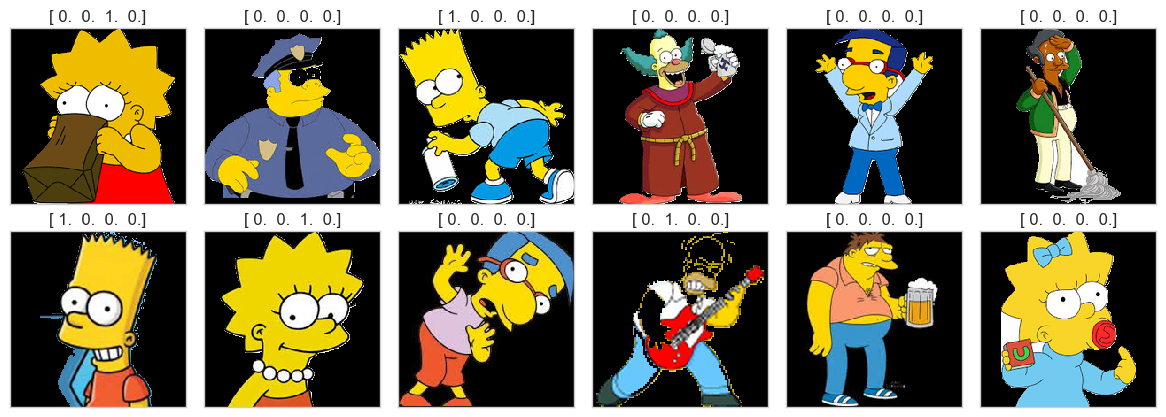

In [124]:
sample_idx = np.random.permutation(range(len(all_images)))
gridplot(all_images[sample_idx][:12], titles=all_labels_oh[sample_idx][:12])

In [125]:
print(pd.DataFrame([
        ["images"] + all_labels_oh.sum(axis=0).tolist() + [(all_labels_oh==0).all(axis=1).sum()],
    ], columns=["dataset", "bart", "homer", "lisa", "marge", "none"], dtype=int))
print("Total num of training set images: ", all_images.shape[0])

  dataset  bart  homer  lisa  marge  none
0  images   121    105    86     49   271
Total num of training set images:  632


# Prepare and tag test set - Extract frames from real episodes

In [126]:
tagged_frames = pd.read_csv("data/preprocessing/test/all-requests-responses.txt", names=["url", "characters", "certainty"])

In [127]:
tagged_frames['oh_enc'] = tagged_frames.characters.apply(
    lambda x: np.zeros((len(label_enc.classes_)-1)) if
        pd.isnull(x) else
        oh_enc.transform(label_enc.transform([ s if s in label_enc.classes_ else 'none' for s in x.split(",")])[:,None]).max(axis=0)[:-1]
)
tagged_frames['filename'] = "data/preprocessing/test/full-episodes-frames/" + tagged_frames.url.str.split("/").apply(lambda x:x[-1])

In [128]:
tagged_frames

,url,characters,certainty,oh_enc,filename
0,http://simpsons-frames.zachmoshe.com/21x01_-_H...,NaN,100,"[0.0, 0.0, 0.0, 0.0]",data/preprocessing/test/full-episodes-frames/2...
1,http://simpsons-frames.zachmoshe.com/21x01_-_H...,homer,null,"[0.0, 1.0, 0.0, 0.0]",data/preprocessing/test/full-episodes-frames/2...
2,http://simpsons-frames.zachmoshe.com/21x01_-_H...,NaN,null,"[0.0, 0.0, 0.0, 0.0]",data/preprocessing/test/full-episodes-frames/2...
3,http://simpsons-frames.zachmoshe.com/21x01_-_H...,bart,null,"[1.0, 0.0, 0.0, 0.0]",data/preprocessing/test/full-episodes-frames/2...
4,http://simpsons-frames.zachmoshe.com/21x01_-_H...,"homer,maggie",null,"[0.0, 1.0, 0.0, 0.0]",data/preprocessing/test/full-episodes-frames/2...
5,http://simpsons-frames.zachmoshe.com/21x01_-_H...,NaN,null,"[0.0, 0.0, 0.0, 0.0]",data/preprocessing/test/full-episodes-frames/2...
6,http://simpsons-frames.zachmoshe.com/21x01_-_H...,homer,null,"[0.0, 1.0, 0.0, 0.0]",data/preprocessing/test/full-episodes-frames/2...
7,http://simpsons-frames.zachmoshe.com/21x01_-_H...,bart,null,"[1.0, 0.0, 0.0, 0.0]",data/preprocessing/test/full-episodes-frames/2...
8,http://simpsons-frames.zachmoshe.com/21x01_-_H...,bart,null,"[1.0, 0.0, 0.0, 0.0]",data/preprocessing/test/full-episodes-frames/2...
9,http://simpsons-frames.zachmoshe.com/21x01_-_H...,bart,null,"[1.0, 0.0, 0.0, 0.0]",data/preprocessing/test/full-episodes-frames/2...


In [129]:
test_labels = np.concatenate(tagged_frames.oh_enc.apply(lambda x: x[None,:]).values)


In [130]:
max_size = np.array([202,360])

test_imgs = np.zeros((tagged_frames.shape[0],) + tuple(max_size) + (3,))

for idx, filename in enumerate(tagged_frames.filename):
    img = scipy.misc.imread(filename, mode='RGB')
    resize_factor = (max_size / img.shape[:max_size.size]).min()
    img = scipy.misc.imresize(img, resize_factor, interp='lanczos')

    
    full_img = np.zeros(max_size.tolist() + [3,])
    test_imgs[idx, 
              (max_size[0] - img.shape[0])//2 : (max_size[0] - img.shape[0])//2 + img.shape[0], 
              (max_size[1] - img.shape[1])//2 : (max_size[1] - img.shape[1])//2 + img.shape[1], : ] = img/255.0


In [131]:
test_imgs.shape

(702, 202, 360, 3)

Look at all images with all ones (all characters)

In [132]:
i = np.argwhere((test_labels==1).all(axis=1)).flatten()

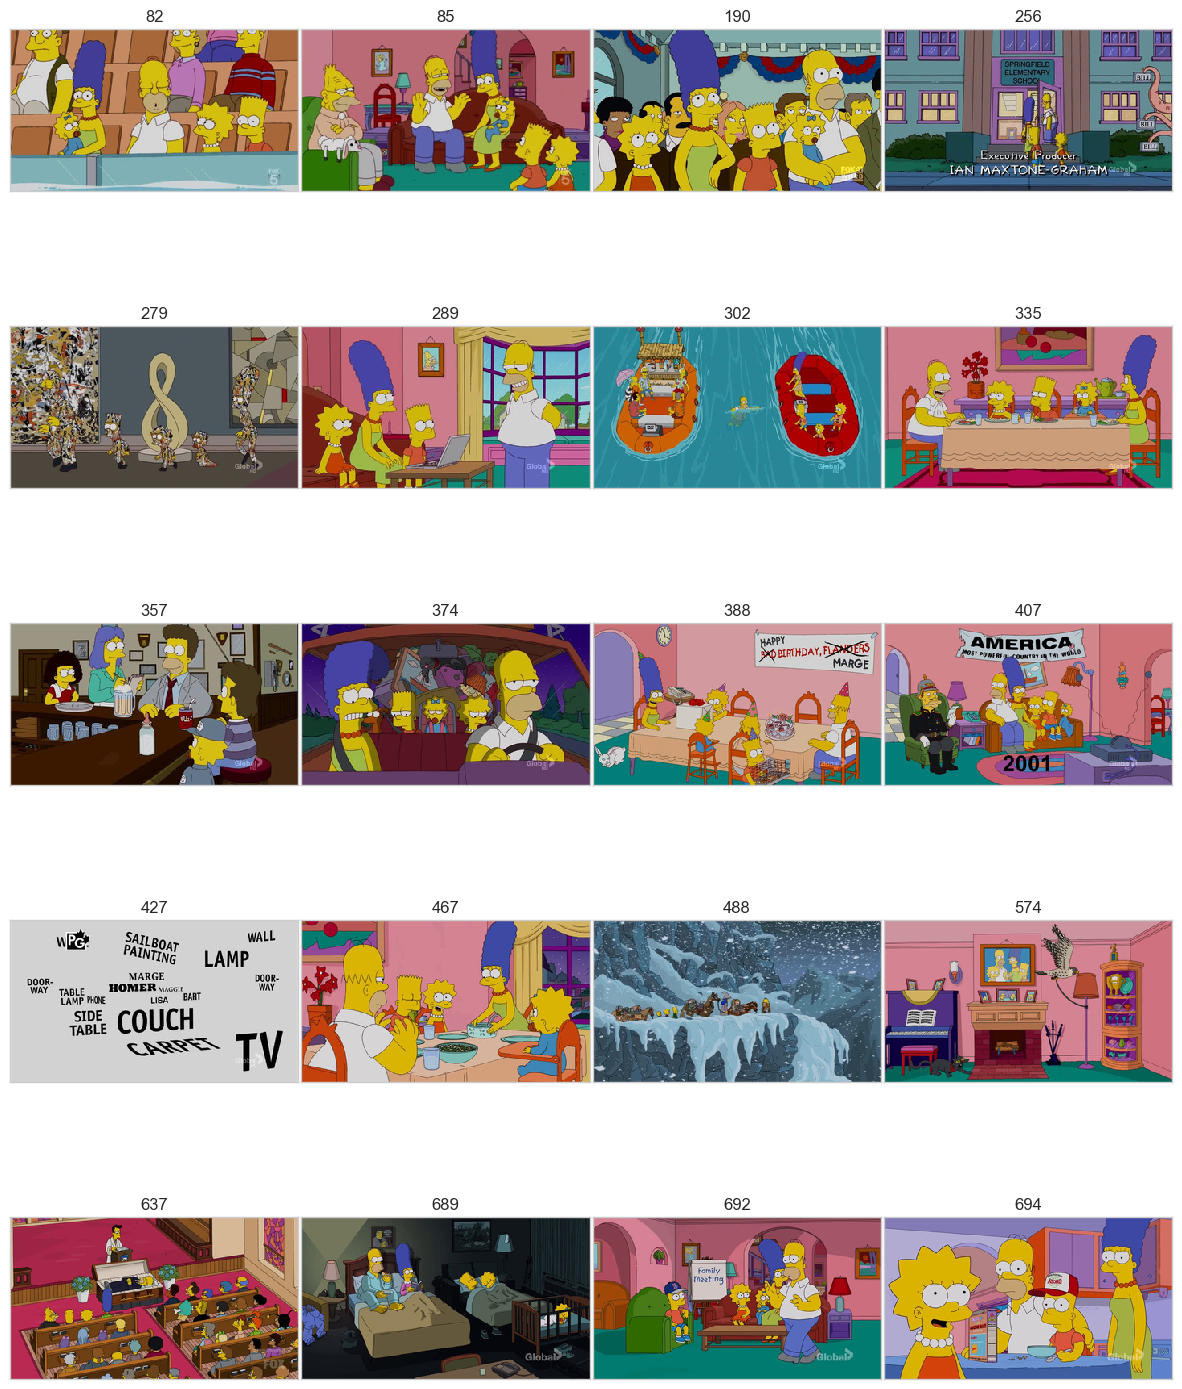

In [133]:
#gridplot(test_imgs[i], titles=test_labels[i])
gridplot(test_imgs[i], titles=i, num_cols=4)

In [134]:
(test_imgs.shape, test_labels.shape)

((702, 202, 360, 3), (702, 4))

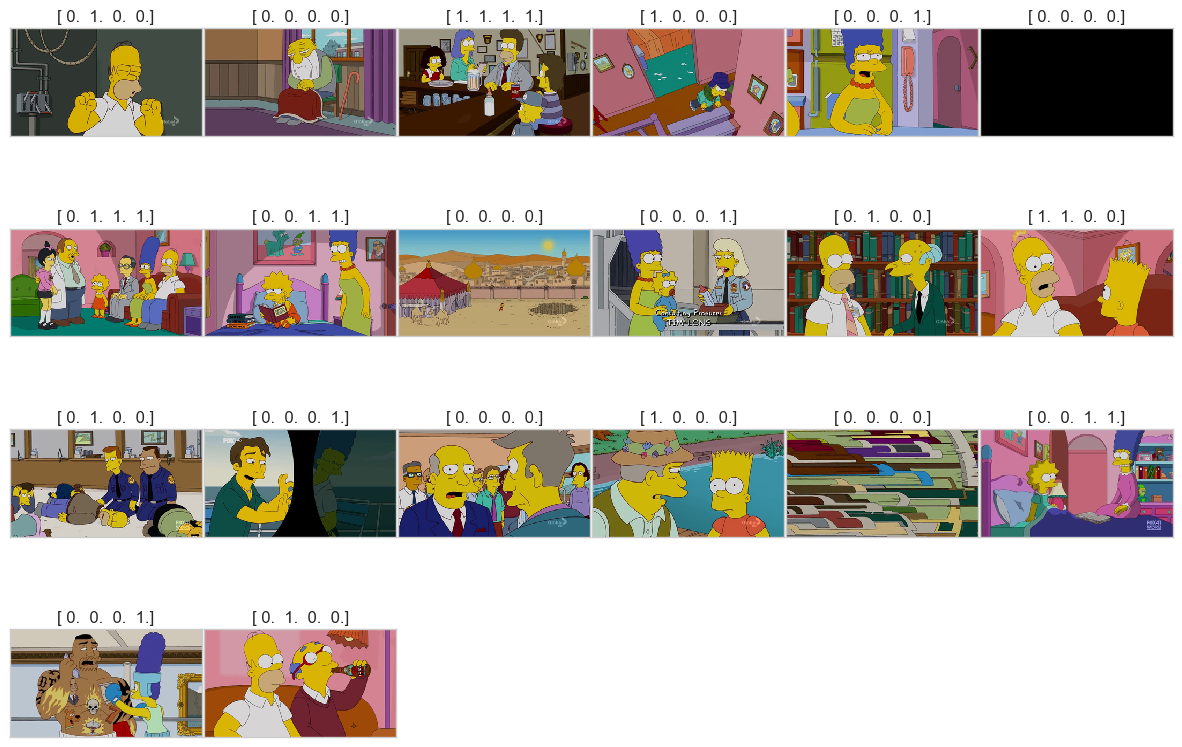

In [135]:
sample_inds = np.random.permutation(range(test_imgs.shape[0]))[:20]
gridplot(test_imgs[sample_inds], titles=test_labels[sample_inds])

# Create datasets

In [136]:
test_labels_classes = np.apply_along_axis(lambda l: ",".join(str(x) for x in l), axis=1, arr=test_labels)
all_labels_oh_classes = np.apply_along_axis(lambda l: ",".join(str(x) for x in l), axis=1, arr=all_labels_oh)

data = Datasets(all_images, all_labels_oh, X_test=test_imgs, y_test=test_labels, train_dev_split=0.25,
               stratify=(all_labels_oh_classes, test_labels_classes))

In [137]:
data.show()

train
  - X: (474, 200, 200, 3)
  - y: (474, 4)
train_dev
  - X: (158, 200, 200, 3)
  - y: (158, 4)
dev
  - X: (351, 202, 360, 3)
  - y: (351, 4)
test
  - X: (351, 202, 360, 3)
  - y: (351, 4)


In [138]:
pd.DataFrame([
        ["train"] + data.train.y.sum(axis=0).tolist(),
        ["train_dev"] + data.train_dev.y.sum(axis=0).tolist(),
        ["dev"] + data.dev.y.sum(axis=0).tolist(),
        ["test"] + data.test.y.sum(axis=0).tolist()
    ], columns=["dataset", "bart", "homer", "lisa", "marge"], dtype=int)

,dataset,bart,homer,lisa,marge
0,train,91,79,64,37
1,train_dev,30,26,22,12
2,dev,74,101,66,65
3,test,73,102,64,64


# Save to file

In [139]:
import pickle
import gzip
import time

with gzip.GzipFile("data/dataset.pickle.zip", 'wb') as f:
    pickle.dump(data, f)

# Old tagging code

In [182]:
from moviepy.editor import VideoFileClip
FRAMES_PER_EPISODE = 100

test_imgs = []
for clip_filename in glob.glob("{}/full-episodes/*".format(TEST_DATA_PATH)):
    clip = VideoFileClip(clip_filename)
    print("extracting frames from {} {}, {:.2f} mins.".format(clip_filename, clip.size, clip.duration/60))
    episode_frames = np.zeros((FRAMES_PER_EPISODE,202,360,3))
    for idx, t in enumerate(np.linspace(0,clip.duration, FRAMES_PER_EPISODE)):
        i = scipy.misc.imresize(clip.get_frame(t), (202,360)) / 255.
        episode_frames[idx, :i.shape[0], :i.shape[1], :] = i

    test_imgs.append(episode_frames)

test_imgs = np.concatenate(test_imgs)

extracting frames from preprocessing/test/full-episodes/s28e02.mkv [720, 404], 21.21 mins.
extracting frames from preprocessing/test/full-episodes/The.Simpsons.S22E04.iNTERNAL.HDTV.x264-TURBO[eztv].mkv [720, 404], 21.93 mins.
extracting frames from preprocessing/test/full-episodes/The.Simpsons.S27E18.HDTV.x264-KILLERS[eztv].mkv [720, 404], 21.29 mins.
extracting frames from preprocessing/test/full-episodes/The.Simpsons.S28E03.HDTV.x264-KILLERS[eztv].mkv [720, 404], 21.59 mins.


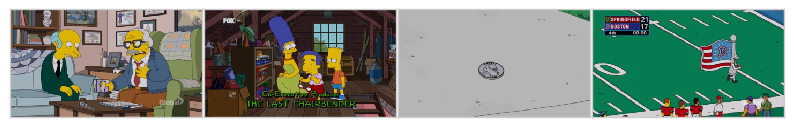

In [183]:
gridplot(test_imgs[[i*FRAMES_PER_EPISODE+10 for i in range(test_imgs.shape[0]//FRAMES_PER_EPISODE)]])

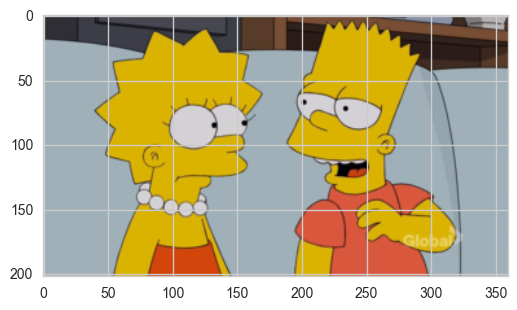

In [184]:
plt.imshow(test_imgs[15])

In [185]:
label_enc.classes_

array(['bart', 'homer', 'lisa', 'maggie', 'marge', 'none'], 
      dtype='<U6')

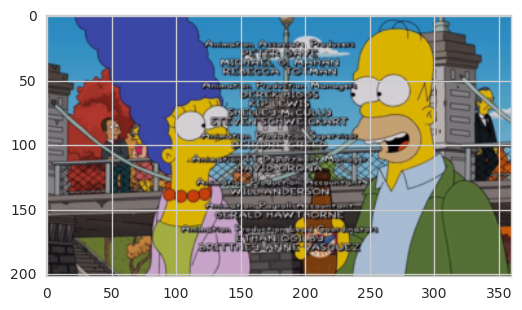

In [165]:
from  ipywidgets import widgets
import IPython.display 
import io 
import base64

characters = [ x for x in label_enc.classes_ if x != 'none' ]
imgs_checkboxes = []
for img in test_imgs:
    plt.imshow(img)
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img_html =  """<img src='data:image/png;base64,{}'/>""".format(base64.b64encode(buf.getvalue()).decode('ascii'))

    checkboxes = [ widgets.Checkbox(False, description=c) for c in characters ]
    checkboxes_vbox = widgets.VBox(checkboxes)
    imgs_checkboxes.append(checkboxes)
    img_cont = widgets.HBox([ widgets.HTML(img_html), checkboxes_vbox ] )
    IPython.display.display(img_cont)
    


In [186]:
%store -r test_labels

In [166]:
#test_labels = np.array([ [ x.value for x in l ] for l in imgs_checkboxes ]).astype(int)
#%store test_labels

Stored 'test_labels' (ndarray)
